# import torch, os, math, gzip, pickle
import matplotlib.pyplot as plt
from pathlib import Path

from torch import tensor
import torchvision as tv
import torchvision.transforms.functional as tvf
from torch.utils.cpp_extension import load_inline

In [4]:
landscape_image = tv.io.read_image("/kaggle/input/landscape/landscapejpg.jpg")
landscape_image.shape # torch.Size([3, 664, 1601])

# These images are stored as unsigned 8 bit integers dtype = uint8

torch.Size([3, 664, 1601])

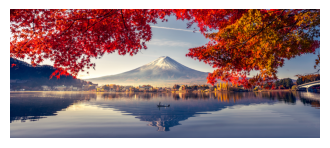

In [5]:
def show_image(x, figsize=(4, 3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis("off")
    # Here we can use torch.permute to allow us to change the ordering of the dimensions however we want it to
    if len(x.shape) == 3:
        # Changing our image from a Channel, Height, Width to Height, Width, Channel as required by matplotlib
        x = x.permute(1, 2, 0)
    
    # By also taking in extra **kwargs then we can unpack them directly into the imshow() function so any extra parameters passed to show_image will be passed directly
    # We also make sure that we set it to the cpu in case it is being stored in the gpu
    plt.imshow(x.cpu(), **kwargs)

show_image(landscape_image)

CPU times: user 45.3 s, sys: 31.8 ms, total: 45.3 s
Wall time: 45.3 s


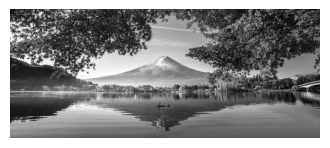

In [21]:
%%time
def rgb_to_grey(image):
    channels, height, width = image.shape
    total_pixels = height * width
    image = image.flatten()

    result = torch.empty(total_pixels, dtype=image.dtype)
    for i in range(total_pixels):
        red = 0.2989 * image[i]
        green = 0.587 * image[i + total_pixels]
        blue = 0.114 * image[i + 2 * total_pixels]

        result[i] = red + green + blue
    
    # Since this array is flattene
    return result.view(height, width)

greyscale_landscape_image = rgb_to_grey(landscape_image)
# We have to specify the colour map so that it works correctly
# This image is incredibly slow so to speed up we can use CUDA
show_image(greyscale_landscape_image, cmap="gray")

In [7]:
# CUDA is setup very differently to CPUs

# RTX GPUs based on the ampere architecture have things called streaming multiprocessors. 
# SMs - Streaming multiprocessors  are fundamental units of execution, each SM can execute multiple threads concurrently
# Each SMs have hundreds of CUDA cores, tensor cores as well as extremely fast cache

# In CUDA all threads in a block have the potential to run concurrently, however the actual concurrency dependso nt eh number of cores that each SM has and the number of threads.
# We can find the parts of the code that typically loop and do not affect eachother, they should not matter the order that they run in and thus should not depend on eachother

# Run the function (kernel) that is done multiple times to do all the work - cuda will simply run this as concurrently as possible.
def rbg_to_grey_kernel(i, image, output, total_pixels):
    output[i] = 0.2989 * image[i] + 0.587 * image[i + total_pixels] + 0.114 * image[i + 2 * total_pixels]

# Ranges of numbers are split into blocks, they are grouped into blocks of 255
# Meaning that the function that is being run will be ran over the nested threads inside the blocks.
# This means that to access a value i = blockID * blockDim + threadID
# Because of this we have to calculate how many blocks we are going to use by taking for example the number of total pixels / threads we are using (e.g 256)
# We have to make sure to math.ceil to round it up but there is a slight problem
# We need to use a guard block - guard blocks prevent the last block i < n from running as not the whole thing will be populated.

# Thread Blocks - are groups of threads taht will ahve shared memory and synchronisation, all threads in a block are executed on the same streaming multiprocessor, meaing they can share resources such as shared memory and synchronise their execution with eachother.
# Shared memory - little bit of cache mmeory in GPUs that is extremely faster however limited in size. Threads in the same bloc kcan share memory with eachother efficiently.
# Register file is register memory that we can use as well as L1 Cache

In [14]:
# Environment variable says - if we get an error stop right away, bad for production, good for debugging during development
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# wurlitzer allows us to see our c++ execution and cuda for print statements - makes life much easier when debugging too
# ninja is a build tool to compile c++
# wurlitzer allows us to print cuda code in notebooks
!pip install -q wurlitzer ninja

/bin/bash: load_ext: command not found


In [9]:
# Load inline allows you to pass cuda code strings to compile, functions to make available to pytorch it will turn it into a python module from c++
def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
    return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                       extra_cuda_cflags=["-O2"] if opt else [], verbose=verbose, name="inline_ext")

In [10]:
cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
'''

In [11]:
# ChatGPT can convert python to c code but this may not be recommended
# the equivalent of our kernel in C would use
# void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n) {
#     int i = blockIdx.x*blockDim.x + threadIdx.x;
#     if (i<n) out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n];
# }

# unsigned char* is uint8 in c
# Essentially saying that x for example is a pointer to unsigned char so integer arrays
# __global__ is a qualifier word that makes it callable from CPU / GPU but executed on Device (global runs it on a new grid of device thredas)
# If you want to call it from the CPU side to run on the GPU we use __global__
# __host__ and __device__ also exist

# . in c++ means call a method of an object
# :: means call a method of a class
# torch::empty()

# CUDA has special syntax taht allows you to run the kernel that you want to call with <<< triple angled brackets
# We have to pass at least the number of blocks adn teh number of threads - there are more things we can pass into it
# kernel<<<num_blocks, num_threads>>>(
#   arguments to the kernel e.g input tensor
#   input.data_ptr<unsigned char>() - converts to a c pointer to the tensor and we want this pointer to be a pointer for uint8s
# )

# By using torch::Tensor input and passing in to torch::empty input.options - we are passing all the kwargs and specific options such as data that makes ++ convenient
# auto variable - don't have to specific type, auto allows c++ to figure out what value it will be

# If there is an error in our kernel then we should always call C10_CUDA_KERNEL_LAUNCH_CHECK(); to make sure there have been no errors
cuda_src = cuda_begin + r'''
__global__ void rgb_to_grayscale_kernel(unsigned char* x, unsigned char* out, int n) {
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i<n) out[i] = 0.2989*x[i] + 0.5870*x[i+n] + 0.1140*x[i+2*n];
}

torch::Tensor rgb_to_grayscale(torch::Tensor input) {
    CHECK_INPUT(input);
    int h = input.size(1);
    int w = input.size(2);
    printf("h*w: %d*%d\n", h, w);
    auto output = torch::empty({h,w}, input.options());
    int threads = 256;
    rgb_to_grayscale_kernel<<<cdiv(w*h,threads), threads>>>(
        input.data_ptr<unsigned char>(), output.data_ptr<unsigned char>(), w*h);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}'''

In [12]:
# List of all the functions that we want to make available to our outside world
cpp_src = "torch::Tensor rgb_to_grayscale(torch::Tensor input);"

In [13]:
# Pass in our cuda source code and our cuda function code then it will run it and compile the code, after compilation it will load the extension module inline
# it creates a main.cpp file that is loaded and creates a module
module = load_cuda(cuda_src, cpp_src, ['rgb_to_grayscale'], verbose=True)

Using /root/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py310_cu121/inline_ext...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu121/inline_ext/build.ninja...
Building extension module inline_ext...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)


[1/3] c++ -MMD -MF main.o.d -DTORCH_EXTENSION_NAME=inline_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1013\" -isystem /opt/conda/lib/python3.10/site-packages/torch/include -isystem /opt/conda/lib/python3.10/site-packages/torch/include/torch/csrc/api/include -isystem /opt/conda/lib/python3.10/site-packages/torch/include/TH -isystem /opt/conda/lib/python3.10/site-packages/torch/include/THC -isystem /usr/local/cuda/include -isystem /opt/conda/include/python3.10 -D_GLIBCXX_USE_CXX11_ABI=1 -fPIC -std=c++17 -c /root/.cache/torch_extensions/py310_cu121/inline_ext/main.cpp -o main.o 
[2/3] /usr/local/cuda/bin/nvcc  -DTORCH_EXTENSION_NAME=inline_ext -DTORCH_API_INCLUDE_EXTENSION_H -DPYBIND11_COMPILER_TYPE=\"_gcc\" -DPYBIND11_STDLIB=\"_libstdcpp\" -DPYBIND11_BUILD_ABI=\"_cxxabi1013\" -isystem /opt/conda/lib/python3.10/site-packages/torch/include -isystem /opt/conda/lib/python3.10/site-packages/torch/include/

Loading extension module inline_ext...


In [16]:
# Now this module besides the defaults that python adds has the rgb_to_grayscale done using cuda
dir(module)
%load_ext wurlitzer

In [17]:
# We need to make an image variable for c that is contiguous if not already and on cuda memory
landscape_image_c = landscape_image.contiguous().cuda()

In [19]:
%%time # - 2.79ms on the gpu is so much faster than 45s
result = module.rgb_to_grayscale(landscape_image_c).cpu()
height, width = result.shape

CPU times: user 1.45 ms, sys: 14 µs, total: 1.47 ms
Wall time: 2.79 ms


In [22]:
# Creating the kernels first in python is much easier to debug and see what is going on and then converting it to C is quite quick, the compilation is not bad at all
# This could be a good way to write the cuda kernel, makes the process more enjoyable and systematic instead of painful

In [23]:
# Mat Mul a fundamental operation in machine learning
# M matrix and N matrix

import gzip,pickle
from urllib.request import urlretrieve
from pathlib import Path
from torch import tensor

MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'
if not path_gz.exists(): 
    urlretrieve(MNIST_URL, path_gz)
    
with gzip.open(path_gz, 'rb') as f: 
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
    x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))

In [24]:
x_train.shape,x_train.type()

(torch.Size([50000, 784]), 'torch.FloatTensor')

In [25]:
# By keeping the -1 we make sure that we keep the 50000 in the dimensions the same then we split the 784 into 28, 28 using reshape
imgs = x_train.reshape((-1,28,28))
imgs.shape

torch.Size([50000, 28, 28])

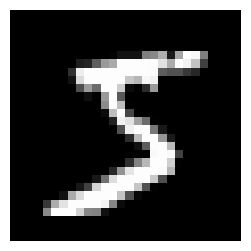

In [28]:
show_image(imgs[0], cmap="gray")

In [32]:
weights = torch.randn(784, 10) # As if this was a neural network with 784 inputs and 10 outputs
weights.shape

torch.Size([784, 10])

In [33]:
matrix_one = x_valid[:5]
matrix_two = weights
matrix_one.shape, matrix_two.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [34]:
one_rows, one_columns = matrix_one.shape
two_rows, two_columns = matrix_two.shape

In [37]:
output = torch.zeros(one_rows, two_columns)
output.shape

torch.Size([5, 10])

In [38]:
for i in range(one_rows):
    for j in range(two_columns):
        for k in range(one_columns):
            output[i,j] += matrix_one[i, k] * matrix_two[k, j]

In [39]:
output

# If you want to change this then we can set numpy print options precision and line width to visualise everything easier
# pytorch also has a linewidth and a precision option to visualise better

tensor([[  1.1038, -10.2817,   6.0438,  -2.1221,   3.5136, -15.6932,   5.8755,
           6.3038,   2.1239,  -1.5143],
        [  1.7525,   7.2242,   9.6593,  -4.1630,  -0.2440,  -2.0273,  11.7280,
           3.8128,   7.0596,  10.7372],
        [ 19.5184,  -8.5138,   1.1314,   4.7740,  -1.2864, -14.8018,  -6.1223,
          -1.3463,  -2.3588,   9.3253],
        [  7.6213, -12.3140,   4.8025,  -7.0983,   2.4132,   8.8270, -10.0991,
           4.6362,   9.2765,  -1.8083],
        [ -0.6073,  -5.9644,  11.9549,  -9.9532, -15.8343, -12.9249,  10.5506,
          -6.1047,   5.0076,  14.5716]])

In [40]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar):
        for j in range(bc):
            for k in range(ac): c[i,j] += a[i,k] * b[k,j]
    return c

In [42]:
%time 
matmul(matrix_one, matrix_two)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 9.54 µs


tensor([[  1.1038, -10.2817,   6.0438,  -2.1221,   3.5136, -15.6932,   5.8755,
           6.3038,   2.1239,  -1.5143],
        [  1.7525,   7.2242,   9.6593,  -4.1630,  -0.2440,  -2.0273,  11.7280,
           3.8128,   7.0596,  10.7372],
        [ 19.5184,  -8.5138,   1.1314,   4.7740,  -1.2864, -14.8018,  -6.1223,
          -1.3463,  -2.3588,   9.3253],
        [  7.6213, -12.3140,   4.8025,  -7.0983,   2.4132,   8.8270, -10.0991,
           4.6362,   9.2765,  -1.8083],
        [ -0.6073,  -5.9644,  11.9549,  -9.9532, -15.8343, -12.9249,  10.5506,
          -6.1047,   5.0076,  14.5716]])

In [43]:
from types import SimpleNamespace as ns

# This is a kernel runner thata now isntead of having two nested loops will have to have two lots of two nested loops, one for each row and col in blocks
# and one for each row and col in threads that will run these functions for each given block and thread
# call the kernel and pass in an object containing the y and x coordinates for both the block adn the threads
def blk_kernel2d(f, blocks, threads, *args):
    for i0 in range(blocks.y):
        for i1 in range(blocks.x):
            for j0 in range(threads.y):
                for j1 in range(threads.x): 
                    f(ns(x=i0,y=i1), ns(x=j0,y=j1), threads, *args)

                    
# We can use this block kernel
# Need to keep rack of the column and the row that we are currently on
# We also need guard blocks to prevent being outside of  columns and rows
# T he calculations are based on the block number and the block size for that dimension along with teh thread we are along that axis
# Guard blocks preventing us from going out of bounds
def matmul_bk(blockidx, threadidx, blockdim, m, n, out, h, w, k):
    r = blockidx.y*blockdim.y + threadidx.y
    c = blockidx.x*blockdim.x + threadidx.x

    if (r>=h or c>=w): return
    o = 0.
    for i in range(k): o += m[r*k+i] * n[i*w+c]
    out[r*w+c] = o

    
# So then we create teh dimensions and make sure they match, and what we do is we then create our output array
# Then we use a namespace that will contain the number threads per block, since we are working 2d we will need to calcualte the number of blocks
# and these numbers will be calculated for the x and the y direction then we can use our block kernel 2d that will run our 2d kernel using blocks
# and we pass our mat multiplication kernel the number of lbocks, the number of threads per block out input and outupt matrices flattened out
def matmul_2d(m, n):
    h,k  = m.shape
    k2,w = n.shape
    assert k==k2, "Sizes do not match"
    output = torch.zeros(h, w, dtype=m.dtype)
    tpb = ns(x=16,y=16)
    blocks = ns(x=math.ceil(w/tpb.x), y=math.ceil(h/tpb.y))
    blk_kernel2d(matmul_bk, blocks, tpb,
                 m.flatten(), n.flatten(), output.flatten(), h, w, k)
    return output

In [44]:
def matmul(a,b):
    (ar,ac),(br,bc) = a.shape,b.shape
    c = torch.zeros(ar, bc)
    for i in range(ar): c[i] = (a[i,:,None] * b).sum(dim=0)
    return c

In [47]:
torch.isclose(output,matmul(matrix_one, matrix_two)).all()

tensor(True)

In [48]:
# We once again create our cuda src code this time using float pointers for out matrix multiplications
# we ekeep track of our row and column value and use our guard blocks we have the kernel defined in c++

# Then our matrix multiplication function will check that het matrix sizes match
# To do assertions we can do TORCH_CHECK(k == n.size(0), "SIZE MISMATCH")
# Should put plenty of thse assertions around

# use torch::zeros( and pass in m.options())
# We can use ceil or the prevoiusly defined cdiv() to calculate the number of blocsk in each dimension using dim3
# After we have initialised these dim3 values then we can pass tehn to our matmul_k kenrnel <<<blocks, tpb>>>(m.data_ptr<float>(), n.data_ptr<float>(), output.data_ptr<float>()
# do a check after C10_CUDA_KERNEL_LAUNCH_CHECK

cuda_src = cuda_begin + r'''
__global__ void matmul_k(float* m, float* n, float* out, int h, int w, int k) {
    int r = blockIdx.y*blockDim.y + threadIdx.y;
    int c = blockIdx.x*blockDim.x + threadIdx.x;

    if (r>=h || c>=w) return;
    float o = 0;
    for (int i = 0; i<k; ++i) o += m[r*k+i] * n[i*w+c];
    out[r*w+c] = o;
}

torch::Tensor matmul(torch::Tensor m, torch::Tensor n) {
    CHECK_INPUT(m); CHECK_INPUT(n);
    int h = m.size(0);
    int w = n.size(1);
    int k = m.size(1);
    TORCH_CHECK(k==n.size(0), "Size mismatch!");
    auto output = torch::zeros({h, w}, m.options());

    dim3 tpb(16,16);
    dim3 blocks(cdiv(w, tpb.x), cdiv(h, tpb.y));
    matmul_k<<<blocks, tpb>>>(
        m.data_ptr<float>(), n.data_ptr<float>(), output.data_ptr<float>(), h, w, k);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}
'''

In [49]:
cpp_src = "torch::Tensor matmul(torch::Tensor m, torch::Tensor n);"

In [50]:
module = load_cuda(cuda_src, cpp_src, ['matmul'])

In [51]:
m1c,m2c = matrix_one.contiguous().cuda(), matrix_two.contiguous().cuda()

In [54]:
output = output.cuda()
torch.isclose(output, module.matmul(m1c, m2c), atol=1e-5).all()

tensor(True, device='cuda:0')

In [ ]:
# This in pytorch is actually faster using @
# Therefore it is important to use pytorch implementations since they will typically be state of the art
# Pytorch in particular takes advantage of the shared memory which out cuda kernel does not
# Hence when doing matrix multiplications use @ 

